The most common data conversions are converting into or out-of row-records. This is what is commonly called pivoting/un-pivot or melt/cast. In cdata terms it is exactly the cases where the control table has two columns.

In these cases we supply convenience functions for specifying the transforms.

For our example we will assume we have some data where for each training epoch of a deep neural net we have the loss on both training and test data.

In [1]:
import io
import pandas
import graphviz
import seaborn as sns
import matplotlib.pyplot as plt

from data_algebra.cdata import *
from transform_to_dot import transform_to_dot

In [2]:
d = pandas.DataFrame({
    'epoch': [10000, 23778, 37556, 51335],
    'Train Error': [0.005455, 0.003538, 0.002815, 0.002408],
    'Test Error': [0.008368, 0.005427, 0.004318, 0.003693],
    })

d

,epoch,Train Error,Test Error
0,10000,0.005455,0.008368
1,23778,0.003538,0.005427
2,37556,0.002815,0.004318
3,51335,0.002408,0.003693


For many graphing tasks we would like the above data to not have many values per row, but only one value per row.

We can achieve this with a classic `melt9()`, or with cdata by asking for a "row records to blocks" transform specification.

In [3]:
mp = pivot_rowrecs_to_blocks(
    attribute_key_column="curve",  # name for new column itself naming measurements
    attribute_value_column="loss (or error)", # name for new column containing measurement values
    record_keys=["epoch"], # columns defining an incoming record
    record_value_columns=["Train Error", "Test Error"],  # columns to take values from
)



And the transform arranges our data for plotting as follows.

In [4]:
d2 = mp.transform(d)
d2

,epoch,curve,loss (or error)
0,10000,Test Error,0.008368
1,10000,Train Error,0.005455
2,23778,Test Error,0.005427
3,23778,Train Error,0.003538
4,37556,Test Error,0.004318
5,37556,Train Error,0.002815
6,51335,Test Error,0.003693
7,51335,Train Error,0.002408


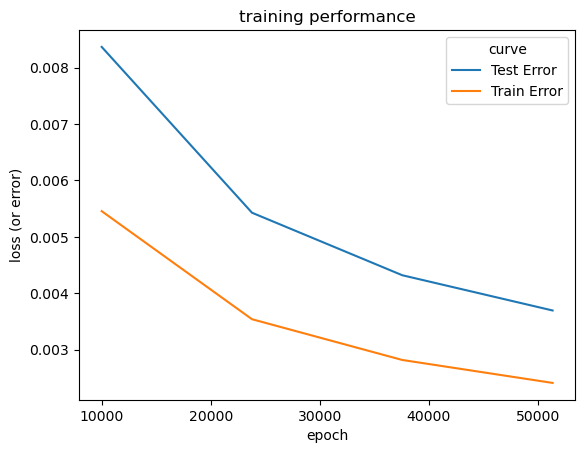

In [5]:
sns.lineplot(
    data=d2,
    x="epoch",
    y="loss (or error)",
    hue="curve"
)
plt.title("training performance")
plt.show()

We can even invert the transform as follows.

In [6]:
mp.inverse().transform(d2)

,epoch,Train Error,Test Error
0,10000,0.005455,0.008368
1,23778,0.003538,0.005427
2,37556,0.002815,0.004318
3,51335,0.002408,0.003693


Or we can define the inverse (with respect to columns preserved) transform by hand.

In [7]:
inv = pivot_blocks_to_rowrecs(
    attribute_key_column="curve",
    attribute_value_column="loss (or error)",
    record_keys=["epoch"],
    record_value_columns=["Train Error", "Test Error"],
)


In [8]:
inv.transform(d2)

,epoch,Train Error,Test Error
0,10000,0.005455,0.008368
1,23778,0.003538,0.005427
2,37556,0.002815,0.004318
3,51335,0.002408,0.003693


One of the great features of cdata is: it can help explain these and other transforms. The transform can tell us what inputs it expects.

In [9]:
example_input = mp.example_input()
value_fields = [k for k in example_input.to_numpy().flatten() if k.endswith(" value")]

(
    example_input
        .style
        .set_properties(**{'background-color': 'red'}, subset=mp.record_keys())
        .set_properties(**{'background-color': 'green'}, subset=mp.input_control_table_key_columns())
)

,epoch,Train Error,Test Error
0,epoch record key,Train Error value,Test Error value


We can even apply the transform to the example input to get an example output.

In [10]:
example_output = mp.transform(example_input)

(
    example_output
        .style
        .set_properties(**{'background-color': 'red'}, subset=mp.record_keys())
        .set_properties(**{'background-color': 'green'}, subset=mp.output_control_table_key_columns())
)

,epoch,curve,loss (or error)
0,epoch record key,Test Error,Test Error value
1,epoch record key,Train Error,Train Error value


In the above examples we have color coded the 3 different types of columns we think about in data transforms:

  * Record keys, in red, which identify which set of rows constitute a single data record.
  * Table keys, in green, which specify where in a single dat record different pieces of data are.
  * Value entires, not colored, which are the data we are working with.

We can also use arrows instead of colors to attempt to illustrate the transform.

In [11]:
dot = transform_to_dot(mp)

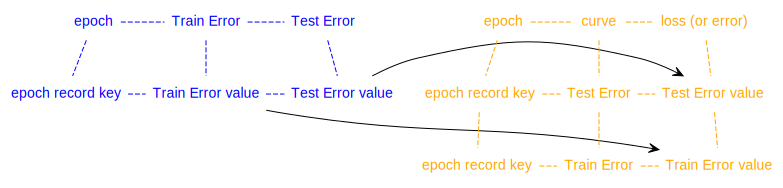

In [12]:
dot